# EDA: 지급건수!=0, 업권분류X, 코사인 클러스터링

이해원

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
pd.set_option('display.max_columns', None)

In [5]:
# cos0 = pd.read_csv('코사인_신협vv.csv')
# cos1 = pd.read_csv('코사인_손해보험.csv')
# cos2 = pd.read_csv('코사인_생명보험.csv')
cos1 = pd.read_csv('코사인_업권분류X_지급건수!=0.csv')

In [6]:
# display(cos0)
display(cos1)
# display(cos2)

,Unnamed: 0,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,총지급금액,총지급 건수,업권,보험계약건수,해지건수,만기건수,해지율,만기율,청구건수,계약유지율,코사인군집
0,0,1,3,2,20,59.0,1,1,1,1,190,1,1,2.0,1.0,2.0,0.50,1.00,1.0,100.0,0
1,1,2,5,2,20,37.0,1,1,1,0,4907,13,1,14.0,7.0,2.0,0.50,0.14,5.0,100.0,3
2,2,2,4,2,20,85.0,1,1,1,0,1160,2,1,1.0,0.0,0.0,0.00,0.00,2.0,100.0,3
3,3,1,5,2,10,62.0,0,1,1,0,520,2,0,8.0,3.0,0.0,0.38,0.00,2.0,100.0,3
4,4,1,4,2,63,120.0,1,1,1,1,989,9,1,5.0,2.0,0.0,0.40,0.00,6.0,100.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6059,6059,1,3,1,0,370.0,1,0,0,0,1390,2,1,3.0,1.0,0.0,0.33,0.00,2.0,100.0,3
6060,6060,1,4,1,0,1000.0,1,0,0,0,141,2,1,4.0,0.0,0.0,0.00,0.00,2.0,100.0,1
6061,6061,1,2,1,0,320.0,1,0,0,1,53,1,1,2.0,0.0,0.0,0.00,0.00,2.0,100.0,1
6062,6062,1,4,1,0,910.0,1,0,0,0,150,1,1,8.0,0.0,1.0,0.00,0.12,3.0,100.0,1


# 1. 컬럼 정리

### 1-(1) index 중복 삭제

In [7]:
cos1 = cos1.drop(columns='Unnamed: 0')
cos1.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,총지급금액,총지급 건수,업권,보험계약건수,해지건수,만기건수,해지율,만기율,청구건수,계약유지율,코사인군집
0,1,3,2,20,59.0,1,1,1,1,190,1,1,2.0,1.0,2.0,0.50,1.00,1.0,100.0,0
1,2,5,2,20,37.0,1,1,1,0,4907,13,1,14.0,7.0,2.0,0.50,0.14,5.0,100.0,3
2,2,4,2,20,85.0,1,1,1,0,1160,2,1,1.0,0.0,0.0,0.00,0.00,2.0,100.0,3
3,1,5,2,10,62.0,0,1,1,0,520,2,0,8.0,3.0,0.0,0.38,0.00,2.0,100.0,3
4,1,4,2,63,120.0,1,1,1,1,989,9,1,5.0,2.0,0.0,0.40,0.00,6.0,100.0,3


### 1-(3) 컬럼 타입별 구분

In [8]:
# # 수치형 컬럼
# ncol = ['CT_PY_PD', 'mean_AMT', '보험계약건수', '해지율', '만기율', '청구건수', '계약유지율']

# # 범주형 컬럼
# catcol = ['GENDER', 'AGE_GROUP', 'CT_PY_CYCLE_CD', 'GBN_CD_1', 'GBN_CD_2', 'GBN_CD_3', 'GBN_CD_4']

# 2. EDA

In [9]:
cos1.describe(include='all')

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,총지급금액,총지급 건수,업권,보험계약건수,해지건수,만기건수,해지율,만기율,청구건수,계약유지율,코사인군집
count,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000
mean,1.532652,4.207124,2.010884,21.764347,85.571775,0.923648,0.833938,0.838555,0.625825,994.322065,2.611478,1.187665,6.182388,1.430409,0.714380,0.215953,0.111854,2.547164,94.227147,1.913094
std,0.498974,1.518475,1.251177,12.903940,115.042655,0.265583,0.372167,0.367971,0.483949,3360.648219,2.688104,0.480261,3.793409,1.825228,1.415106,0.254278,0.207372,1.725062,20.665058,1.421728
min,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,2.000000,20.000000,38.000000,1.000000,1.000000,1.000000,0.000000,120.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,100.000000,0.000000
50%,2.000000,4.000000,2.000000,20.000000,66.416667,1.000000,1.000000,1.000000,1.000000,290.000000,2.000000,1.000000,5.000000,1.000000,0.000000,0.150000,0.000000,2.000000,100.000000,2.000000
75%,2.000000,5.000000,2.000000,20.000000,108.000000,1.000000,1.000000,1.000000,1.000000,720.000000,3.000000,1.000000,8.000000,2.000000,1.000000,0.330000,0.170000,3.000000,100.000000,3.000000
max,2.000000,8.000000,99.000000,99.000000,4400.000000,1.000000,1.000000,1.000000,1.000000,142950.000000,71.000000,2.000000,22.000000,15.000000,15.000000,2.000000,2.000000,14.000000,100.000000,4.000000


In [10]:
cos1['코사인군집'].value_counts()

코사인군집
3    2196
0    1768
2     990
4     641
1     469
Name: count, dtype: int64

### a. GENDER

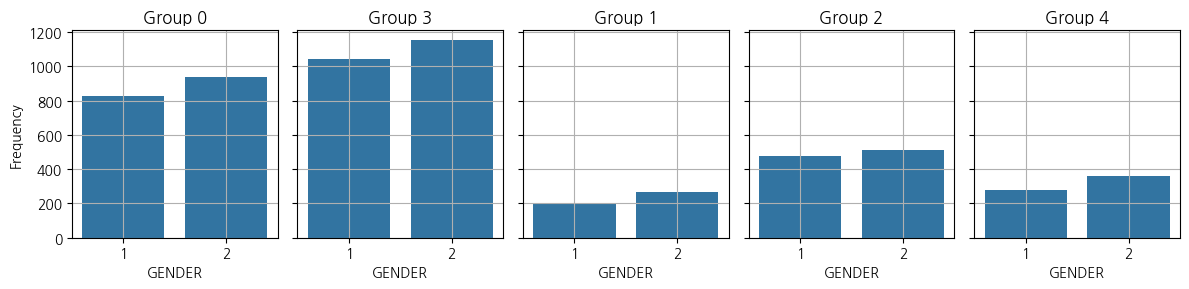

In [11]:
# 're_group'의 유니크한 값을 찾기
unique_group = cos1['코사인군집'].unique()

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == group]

    # countplot 그리기
    sns.countplot(x='GENDER', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('GENDER')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

### b. mean_AMT

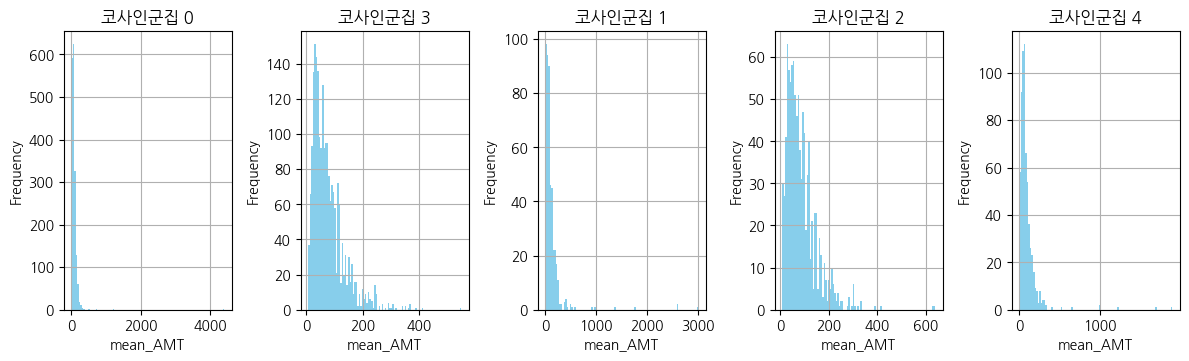

In [12]:
# 'CT_PY_CYCLE_CD'의 유니크한 값을 찾기
unique_cycles = cos1['코사인군집'].unique()

plt.figure(figsize=(12, 10))

# 각 유니크한 'CT_PY_CYCLE_CD' 값에 대해 서브플롯 생성
for i, cycle in enumerate(unique_cycles):#enumerate를 통해 인덱스 값과 값을 받아온다.
    plt.subplot(3,len(unique_cycles),i+1)
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == cycle]
    # 히스토그램 그리기
    plt.hist(subset['mean_AMT'], bins=100, color='skyblue')
    plt.title(f'코사인군집 {cycle}')
    plt.xlabel('mean_AMT')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

### c. 계약유지율

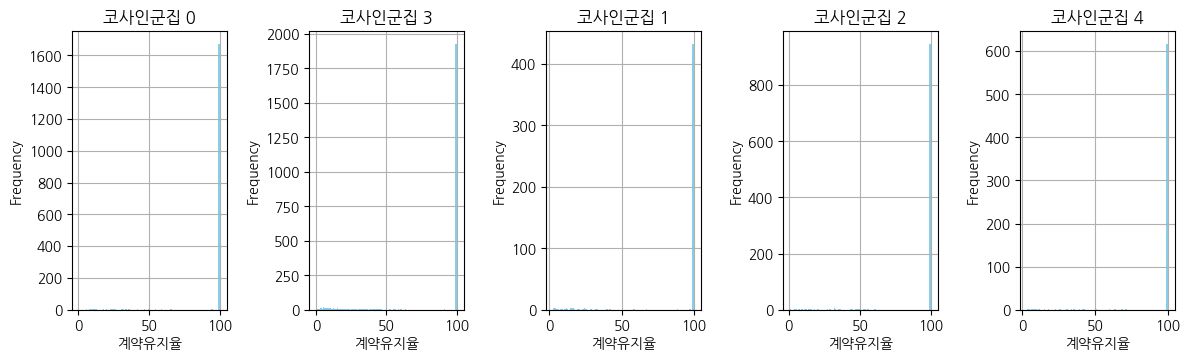

In [13]:
# 'CT_PY_CYCLE_CD'의 유니크한 값을 찾기
unique_cycles = cos1['코사인군집'].unique()

plt.figure(figsize=(12, 10))

# 각 유니크한 'CT_PY_CYCLE_CD' 값에 대해 서브플롯 생성
for i, cycle in enumerate(unique_cycles):#enumerate를 통해 인덱스 값과 값을 받아온다.
    plt.subplot(3,len(unique_cycles),i+1)
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == cycle]
    # 히스토그램 그리기
    plt.hist(subset['계약유지율'], bins=100, color='skyblue')
    plt.title(f'코사인군집 {cycle}')
    plt.xlabel('계약유지율')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

### d. CT_PY_PD

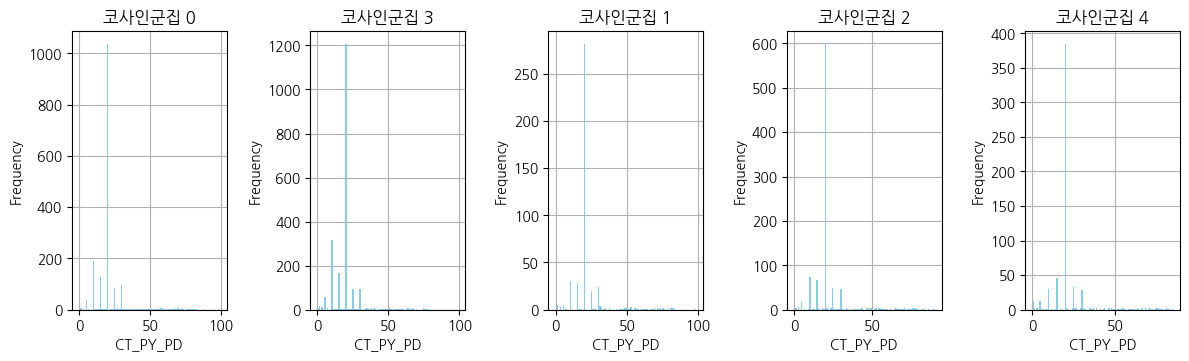

In [14]:
# 'CT_PY_CYCLE_CD'의 유니크한 값을 찾기
unique_cycles = cos1['코사인군집'].unique()

plt.figure(figsize=(12, 10))

# 각 유니크한 'CT_PY_CYCLE_CD' 값에 대해 서브플롯 생성
for i, cycle in enumerate(unique_cycles):#enumerate를 통해 인덱스 값과 값을 받아온다.
    plt.subplot(3,len(unique_cycles),i+1)
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == cycle]
    # 히스토그램 그리기
    plt.hist(subset['CT_PY_PD'], bins=100, color='skyblue')
    plt.title(f'코사인군집 {cycle}')
    plt.xlabel('CT_PY_PD')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

### e. 청구건수

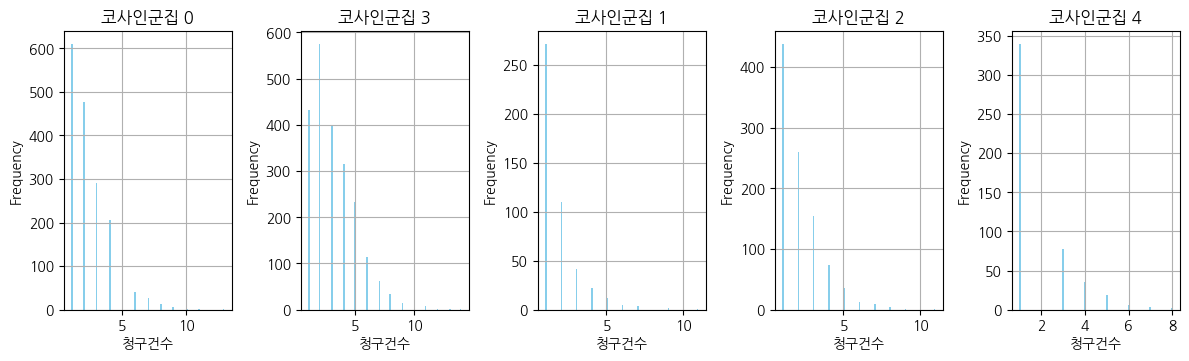

In [15]:
# 'CT_PY_CYCLE_CD'의 유니크한 값을 찾기
unique_cycles = cos1['코사인군집'].unique()

plt.figure(figsize=(12, 10))

# 각 유니크한 'CT_PY_CYCLE_CD' 값에 대해 서브플롯 생성
for i, cycle in enumerate(unique_cycles):#enumerate를 통해 인덱스 값과 값을 받아온다.
    plt.subplot(3,len(unique_cycles),i+1)
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == cycle]
    # 히스토그램 그리기
    plt.hist(subset['청구건수'], bins=100, color='skyblue')
    plt.title(f'코사인군집 {cycle}')
    plt.xlabel('청구건수')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

### f. 총지급금액

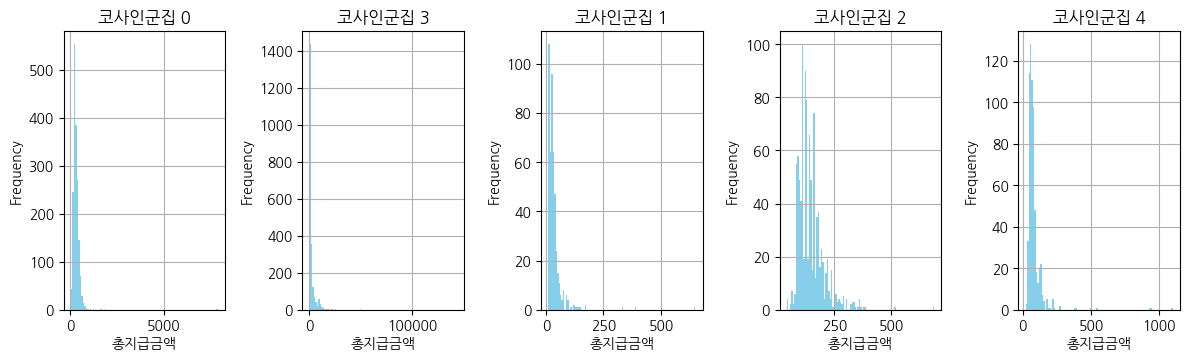

In [16]:
# 'CT_PY_CYCLE_CD'의 유니크한 값을 찾기
unique_cycles = cos1['코사인군집'].unique()

plt.figure(figsize=(12, 10))

# 각 유니크한 'CT_PY_CYCLE_CD' 값에 대해 서브플롯 생성
for i, cycle in enumerate(unique_cycles):#enumerate를 통해 인덱스 값과 값을 받아온다.
    plt.subplot(3,len(unique_cycles),i+1)
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == cycle]
    # 히스토그램 그리기
    plt.hist(subset['총지급금액'], bins=100, color='skyblue')
    plt.title(f'코사인군집 {cycle}')
    plt.xlabel('총지급금액')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

### g. 총지급 건수

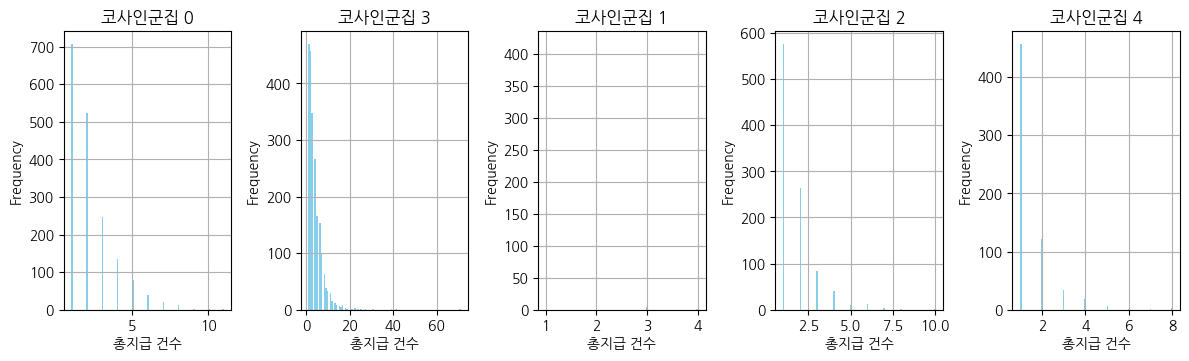

In [17]:
# 'CT_PY_CYCLE_CD'의 유니크한 값을 찾기
unique_cycles = cos1['코사인군집'].unique()

plt.figure(figsize=(12, 10))

# 각 유니크한 'CT_PY_CYCLE_CD' 값에 대해 서브플롯 생성
for i, cycle in enumerate(unique_cycles):#enumerate를 통해 인덱스 값과 값을 받아온다.
    plt.subplot(3,len(unique_cycles),i+1)
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == cycle]
    # 히스토그램 그리기
    plt.hist(subset['총지급 건수'], bins=100, color='skyblue')
    plt.title(f'코사인군집 {cycle}')
    plt.xlabel('총지급 건수')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

### h. 업권

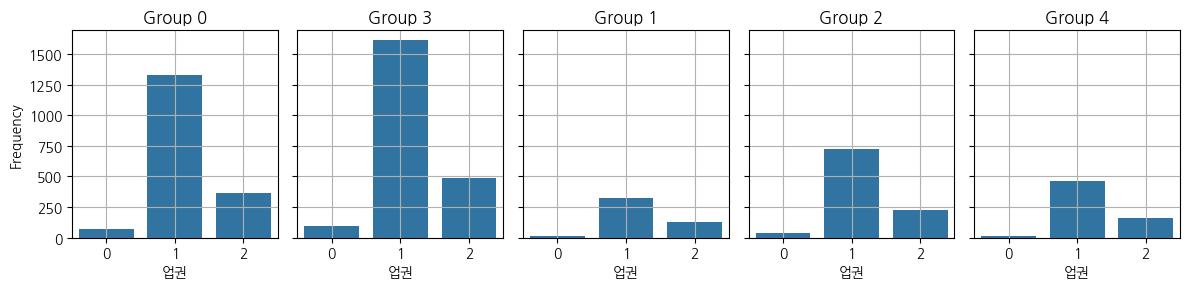

In [18]:
# 're_group'의 유니크한 값을 찾기
unique_group = cos1['코사인군집'].unique()

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == group]

    # countplot 그리기
    sns.countplot(x='업권', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('업권')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

### i. GBN_CD_1~4

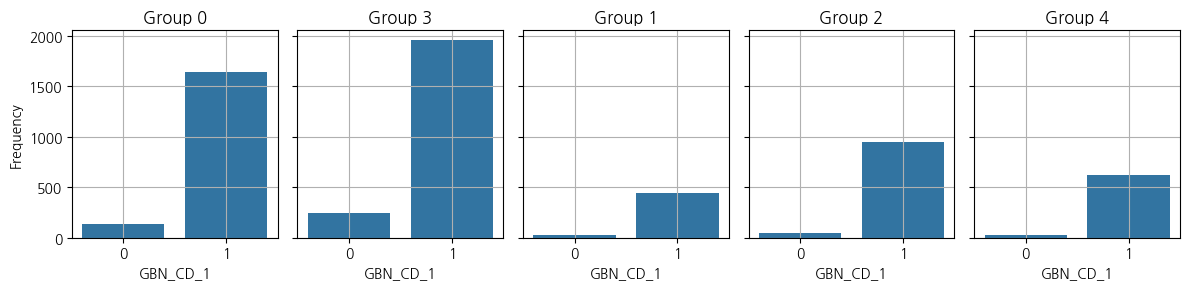

In [19]:
# 're_group'의 유니크한 값을 찾기
unique_group = cos1['코사인군집'].unique()

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == group]

    # countplot 그리기
    sns.countplot(x='GBN_CD_1', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('GBN_CD_1')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

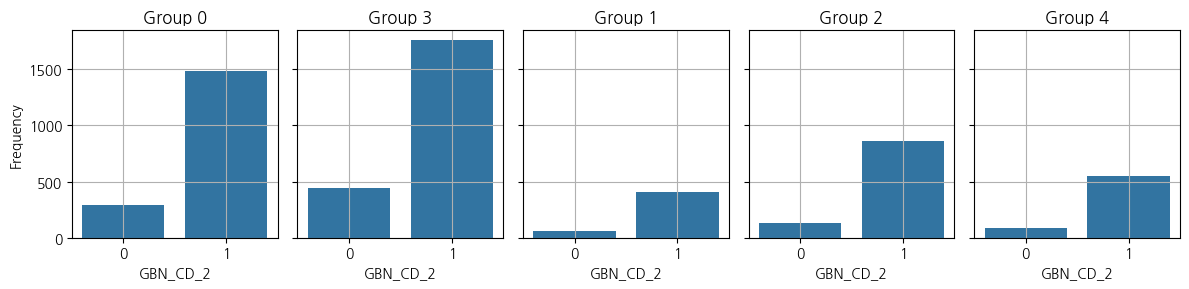

In [20]:
# 're_group'의 유니크한 값을 찾기
unique_group = cos1['코사인군집'].unique()

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == group]

    # countplot 그리기
    sns.countplot(x='GBN_CD_2', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('GBN_CD_2')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

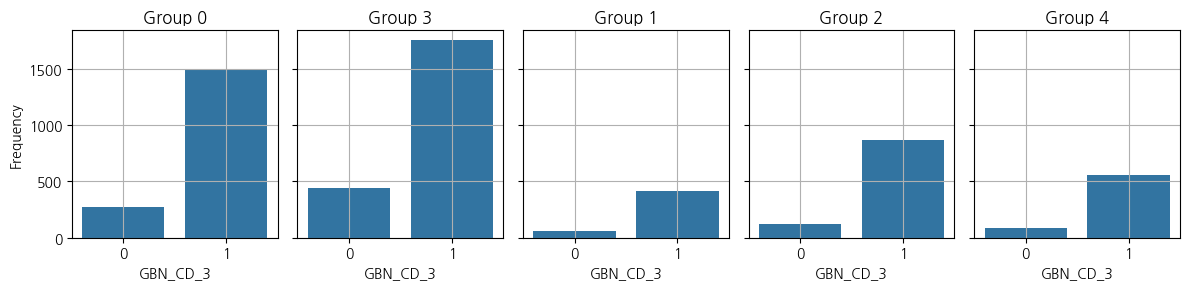

In [21]:
# 're_group'의 유니크한 값을 찾기
unique_group = cos1['코사인군집'].unique()

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == group]

    # countplot 그리기
    sns.countplot(x='GBN_CD_3', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('GBN_CD_3')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

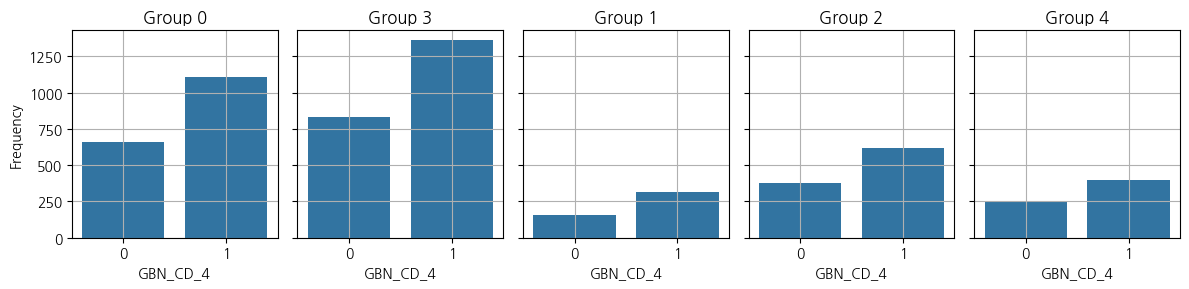

In [22]:
# 're_group'의 유니크한 값을 찾기
unique_group = cos1['코사인군집'].unique()

# 서브플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=len(unique_group), figsize=(12, 3),sharey=True)

# 각 유니크한 're_group' 값에 대해 서브플롯 생성
for ax, group in zip(axes, unique_group):
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == group]

    # countplot 그리기
    sns.countplot(x='GBN_CD_4', data=subset, ax=ax)
    ax.set_title(f'Group {group}')
    ax.set_xlabel('GBN_CD_4')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

### j. 보험계약건수

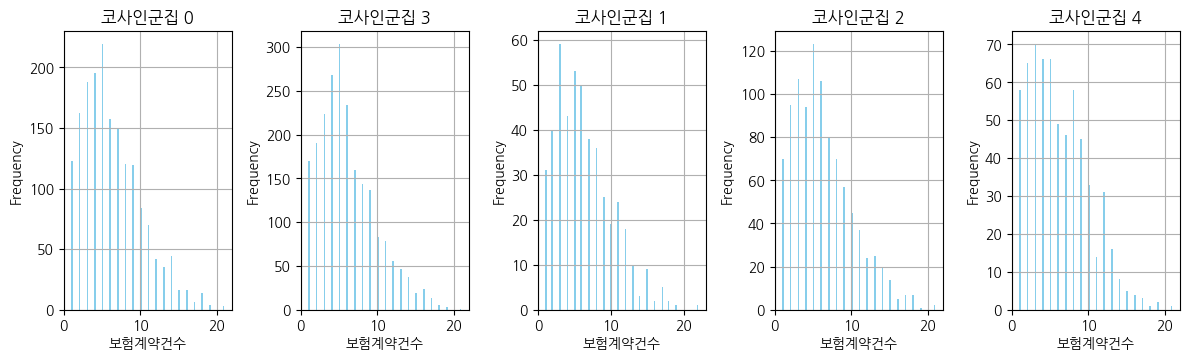

In [23]:
# 'CT_PY_CYCLE_CD'의 유니크한 값을 찾기
unique_cycles = cos1['코사인군집'].unique()

plt.figure(figsize=(12, 10))

# 각 유니크한 'CT_PY_CYCLE_CD' 값에 대해 서브플롯 생성
for i, cycle in enumerate(unique_cycles):#enumerate를 통해 인덱스 값과 값을 받아온다.
    plt.subplot(3,len(unique_cycles),i+1)
    # 현재 cycle 값에 해당하는 데이터 필터링
    subset = cos1[cos1['코사인군집'] == cycle]
    # 히스토그램 그리기
    plt.hist(subset['보험계약건수'], bins=100, color='skyblue')
    plt.title(f'코사인군집 {cycle}')
    plt.xlabel('보험계약건수')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()